# Pip Installs

In [1]:
%%capture

!pip install librosa
!pip install tensorflow
!pip install numpy==1.23.5
!pip install pysoundfile

Tensor flow does not work with Numpy 2.0 onward so make sure that 

# Imports

Below are the necessary imports 

In [2]:
#Imports
from pydub import AudioSegment as audio
import os
import numpy as np
import librosa
#Tensor Flow needs numpy at 1.23.5
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import re 
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# File Creation

### Creating File Paths

In [3]:
unprocessed_data_dir = os.path.abspath('') + "/Unprocessed_Wav_Files"
proccesed_data_dir = os.path.abspath('') + "/Processed_Wav_Files"

Steps
- go through all files in the unprocessed wav files
- break up all files so they are split by 1 second
- use regex to get the file name minus the .wav at the end to make new 1 second wav files
- save each of the files into the processed wav folder

Resample the unproccessed audio files for speaker recognition. This is needed for tensorflow and keras

In [4]:
#This was a test for the fixing the audio with a single thing

"""
f_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
new_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)
sf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)
"""


'\nf_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")\narr, hz = librosa.load(f_path, sr = None)\nnew_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)\nsf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)\n'

### Changes the Unporcessed_Wav_Files into 16000 hz

This is necessary for speaker recognition model training and feature extractions

In [4]:
for file in os.listdir(unprocessed_data_dir):
    f_path = os.path.join(unprocessed_data_dir, file)
    arr, hz = librosa.load(f_path,sr = None)
    if hz != 16000:
        new_f = librosa.resample(arr, orig_sr = hz, target_sr = 16000)
        sf.write(f_path, new_f, 16000)

This is a test

In [35]:
f_path = os.path.join(unprocessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
print(hz)

16000


### Separates the files into 1 second intervals

In [100]:
for filename in os.listdir(unprocessed_data_dir):
    if filename.endswith(".wav"):
        hearing = audio.from_wav(os.path.join(unprocessed_data_dir,filename))
        speaker = filename.removesuffix(".wav")
        #name of congress person for processed_wav_files folder
        congress_name = speaker[:re.search(r"\d+",speaker).start()] 
        #start duration in milliseconds for audio recording start
        t1 = 0
        #end duration in milliseconds for audio recording start
        t2 = 1000
        #second of the clip
        second = 1
        total_time = hearing.duration_seconds*1000
        # Goes through all of the large audio files, splits them into 1 second audio files
        # and saves to the speaker name folder
        while t2 <= total_time:
            new_audio = hearing[t1:t2]
            #arr, hz = librosa.load(new_audio, sr = None)
            try:
                os.makedirs(f"{proccesed_data_dir}/{congress_name}")
                new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
            except:
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
                new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
            t1 += 1000
            t2 += 1000
            second += 1

Check the Hz of a split file

In [96]:
a,b = librosa.load(os.path.abspath('')  + "/Processed_Wav_Files/stephenCohen/stephenCohen40173Clip1_57.wav", sr = None)
print(b)

16000


## Feature Extraction

    The code below captures the spectral characteristics of the congress person speaking
    during the audio clip. This process mimics how people perceive and identify voices.
    The feature extraction below uses features which are derived from the Mel Scale and 
    cepstrum. These features are then used to train the model to identify patterns in 
    speaker voices. 

In [80]:
def feature_extract (data_dir):
    features = []
    labels = []
    num = 1
    for foldr in os.listdir(data_dir):
        if foldr != ".DS_Store":
            for file in os.listdir(f"{data_dir}/{foldr}"):
                arr, hz = librosa.load(os.path.join(data_dir,foldr,file), sr = None, duration =  1)
                mfccs = librosa.feature.mfcc(y = arr, sr = hz, n_mfcc = 13)
                mfccs = StandardScaler().fit_transform(mfccs)
                features.append(mfccs.T)
                labels.append(foldr)
                print(f"{num} {file}")
                num += 1
    return np.array(features), np.array(labels)           
features, labels = feature_extract(proccesed_data_dir)

1 jamesJordan40175Clip1_233.wav
2 jamesJordan40175Clip1_227.wav
3 jamesJordan40175Clip1_186.wav
4 jamesJordan40175Clip1_192.wav
5 jamesJordan40175Clip1_179.wav
6 jamesJordan40175Clip1_145.wav
7 jamesJordan40175Clip1_151.wav
8 jamesJordan40175Clip1_18.wav
9 jamesJordan40175Clip1_24.wav
10 jamesJordan40175Clip1_30.wav
11 jamesJordan40175Clip1_31.wav
12 jamesJordan40175Clip1_25.wav
13 jamesJordan40175Clip1_19.wav
14 jamesJordan40175Clip1_150.wav
15 jamesJordan40175Clip1_144.wav
16 jamesJordan40175Clip1_178.wav
17 jamesJordan40175Clip1_193.wav
18 jamesJordan40175Clip1_187.wav
19 jamesJordan40175Clip1_226.wav
20 jamesJordan40175Clip1_232.wav
21 jamesJordan40175Clip1_218.wav
22 jamesJordan40175Clip1_224.wav
23 jamesJordan40175Clip1_230.wav
24 jamesJordan40175Clip1_8.wav
25 jamesJordan40175Clip1_191.wav
26 jamesJordan40175Clip1_185.wav
27 jamesJordan40175Clip1_152.wav
28 jamesJordan40175Clip1_146.wav
29 jamesJordan40175Clip1_33.wav
30 jamesJordan40175Clip1_27.wav
31 jamesJordan40175Clip1_26.w

/var/folders/jc/_gm_0_h52yn5kp7x5_l6q7gw0000gn/T/ipykernel_34341/255333503.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(features), np.array(labels)


In [99]:
print(f"The number of frames the audio was divided into was {len(features[5590])}\n")
print(f"This is represents one frame {features[0][0]}")

The number of frames the audio was divided into was 94

This is represents one frame [-3.360361   -0.1903183   0.77904576  0.15367031  0.22454423  0.7346955
  0.19315235  0.37246782  0.30784097  0.07275002  0.29632047  0.19204979
  0.22414224]


In [82]:
for i, feature_set in enumerate(features):
    if feature_set.shape != (32, 13):
        print(f"Mismatch at index {i}, shape: {feature_set.shape}")

print(features[5590])

Mismatch at index 5590, shape: (94, 13)
[[-3.4536846   0.48114875  0.39474386 ...  0.21482122  0.23562574
   0.24051416]
 [-3.4546144   0.49470994  0.37756917 ...  0.23110554  0.22854178
   0.22477458]
 [-3.4584556   0.43469265  0.3636712  ...  0.24323826  0.22525778
   0.20955104]
 ...
 [-3.3264742   0.71809465 -0.08461419 ...  0.20392159  0.13089058
   0.00904747]
 [-3.3149776   0.8144305  -0.06810201 ...  0.09180253  0.04598849
   0.05216311]
 [-3.3231947   0.8602023  -0.0780787  ...  0.04884682  0.03712599
   0.05751014]]


### Feature Visualization

In [71]:
for feature_set, label in zip(features, labels[74:150]):
    print(f"Label: {label}, Features Shape: {feature_set.shape}")
    print(feature_set[0])  # Optionally print the actual features
    print("-" * 40)  # Separator for readability

Label: jamesJordan, Features Shape: (32, 13)
[-3.360361   -0.1903183   0.77904576  0.15367031  0.22454423  0.7346955
  0.19315235  0.37246782  0.30784097  0.07275002  0.29632047  0.19204979
  0.22414224]
----------------------------------------
Label: jamesJordan, Features Shape: (32, 13)
[-3.004173    1.3296394  -0.24910702  1.3453428   0.13564226 -0.1008335
  0.27885127  0.10520647  0.15796548 -0.3386022   0.19895187  0.18986304
 -0.04874685]
----------------------------------------
Label: jamesJordan, Features Shape: (32, 13)
[-3.0829401e+00  1.5331542e+00  1.5818969e-04  9.0373278e-01
  2.7616814e-01 -1.6860381e-01  1.2954178e-01  5.0936118e-02
  3.0296618e-01 -2.4682966e-01  1.3251595e-01  1.8341005e-01
 -1.4209974e-02]
----------------------------------------
Label: jamesJordan, Features Shape: (32, 13)
[-3.2771137   0.8414707   0.16856258  1.0565054   0.38853514  0.03541012
  0.28715527  0.11213993  0.25858703 -0.12735942 -0.05219261  0.27088258
  0.03741675]
-------------------

### Training and splitting the data

In [59]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= .2, random_state= 42)

In [60]:
#Original shape shows n_samples, n_features, and n_channels
print(X_train.shape)
print(y_train.shape)

(4878,)
(4878,)


### Reshape for SVM since it takes 2D arrays

In [54]:
X_train_SVM = X_train.reshape(X_train.shape[0], -1)
X_test_SVM = X_test.reshape(X_test.shape[0], -1)

In [55]:
print(X_train_SVM.shape)
print(y_train.shape)
#print(X_train_SVM)
print(y_train)

(4878, 1)
(4878,)
['brianMast' 'christopherSmith' 'christopherSmith' ... 'stephenCohen'
 'stephenCohen' 'brianMast']


### Trying the SVM approach

In [56]:
clm = SVC(kernel="linear")

clm.fit(X_train_SVM,y_train)

y_predict = clm.predict(X_test_SVM)
incorrect = y_predict != y_test
print((len(y_test) - sum(incorrect))/len(y_test))

ValueError: setting an array element with a sequence.

In [ ]:
total = 0
predict = 0
real_dict = {}
pred_dict = {}

for i in labels:
    real_dict[i] = 0
    pred_dict[i] = 0

for pred, real in zip(y_predict,y_test):
    real_dict[real] += 1
    pred_dict[real] += 1 if real == pred else 0
for name in real_dict:
    print(
         f"{name} \n\taccuracy = {pred_dict[name]/real_dict[name]}" 
         f"\n\tpredict/real = {pred_dict[name]}/{real_dict[name]}"
         )

jamesJordan 
	accuracy = 0.7058823529411765
	predict/real = 48/68
kevinKiley 
	accuracy = 0.717391304347826
	predict/real = 33/46
victoriaSpartz 
	accuracy = 0.76
	predict/real = 19/25
richardLarsen 
	accuracy = 0.8409090909090909
	predict/real = 37/44
samuelGraves 
	accuracy = 0.5945945945945946
	predict/real = 44/74
christineSmith 
	accuracy = 0.6
	predict/real = 6/10
michaelQuigley 
	accuracy = 0.6666666666666666
	predict/real = 6/9
addisonWilson 
	accuracy = 0.9238578680203046
	predict/real = 182/197
jerroldNadler 
	accuracy = 0.8133333333333334
	predict/real = 61/75
michaelLawler 
	accuracy = 0.4666666666666667
	predict/real = 7/15
stephenCohen 
	accuracy = 0.6845637583892618
	predict/real = 102/149
thomasMcclintock 
	accuracy = 0.5
	predict/real = 24/48
sheldonWhitehouse 
	accuracy = 0.5
	predict/real = 8/16


## Try RNN LSTM approach

### Label Encoding

In [ ]:
label_encoder = LabelEncoder()
label_enc = label_encoder.fit_transform(labels)
#label_encoder.classes_ = np.array(labels)
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(features, label_enc, test_size=0.2, random_state=42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(label_enc)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
history = model.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=32)

IndexError: tuple index out of range

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Prediction time: 0.8897321224212646
776
Test Evaluation Accuracy: 0.8466494845360825


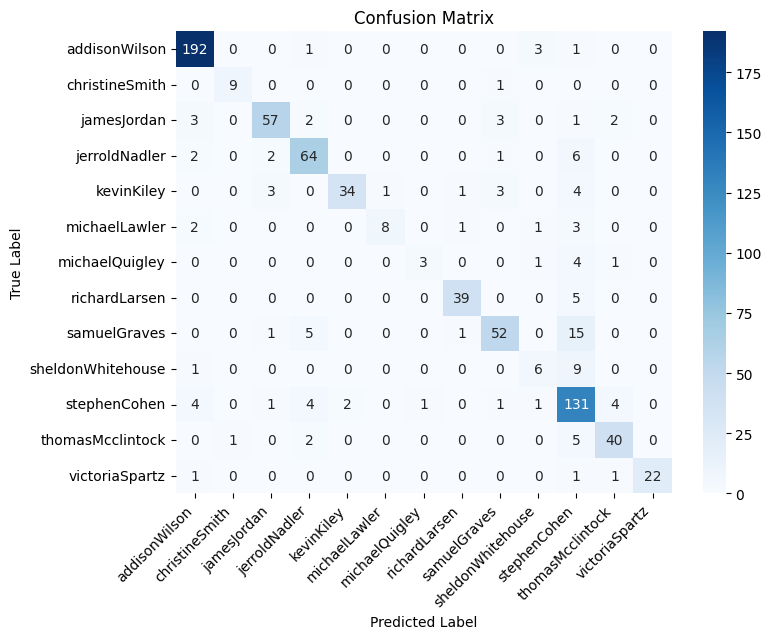

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
start_time = time.time()
y_pred_probabilities = model.predict(X_test_rnn)
print("Prediction time:", time.time() - start_time)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print(len(y_pred_decoded))
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Try GRU RNN approach

In [ ]:
num_speakers = 13
np.random.seed(42)
tf.random.set_seed(42)

y_train_one_hot = to_categorical(y_train_rnn, num_classes=num_speakers)  # n = number of speakers
y_test_one_hot = to_categorical(y_test_rnn, num_classes=num_speakers)

gru = Sequential()
gru.add(GRU(128, return_sequences = False, input_shape = (32,13))) 
gru.add(BatchNormalization())
gru.add(Dropout(.5))
gru.add(Dense(num_speakers, activation = 'softmax'))
# Compile the model
gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
gru.summary()

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 128)            │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,101 (223.05 KB)

 Trainable params: 56,845 (222.05 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = gru.fit(X_train_rnn, y_train_one_hot,
                  epochs=20,
                  batch_size=32,
                  validation_data=(X_test_rnn, y_test_one_hot),
                  callbacks=[early_stopping])

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2548 - loss: 2.6302 - val_accuracy: 0.2784 - val_loss: 2.4174
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6242 - loss: 1.2020 - val_accuracy: 0.3479 - val_loss: 1.8707
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6959 - loss: 0.9731 - val_accuracy: 0.4304 - val_loss: 1.5369
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7446 - loss: 0.8409 - val_accuracy: 0.3918 - val_loss: 1.8989
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7554 - loss: 0.8002 - val_accuracy: 0.4704 - val_loss: 1.5274
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7523 - loss: 0.7648 - val_accuracy: 0.3338 - val_loss: 3.8339
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7774 - loss: 0.6955 - val_accuracy: 0.4858 - val_loss: 2.1215
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7821 - loss: 0.6853 - val_accuracy: 0.5760 - v

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Prediction time: 457.8518080711365
776
Test Evaluation Accuracy: 0.7177835051546392


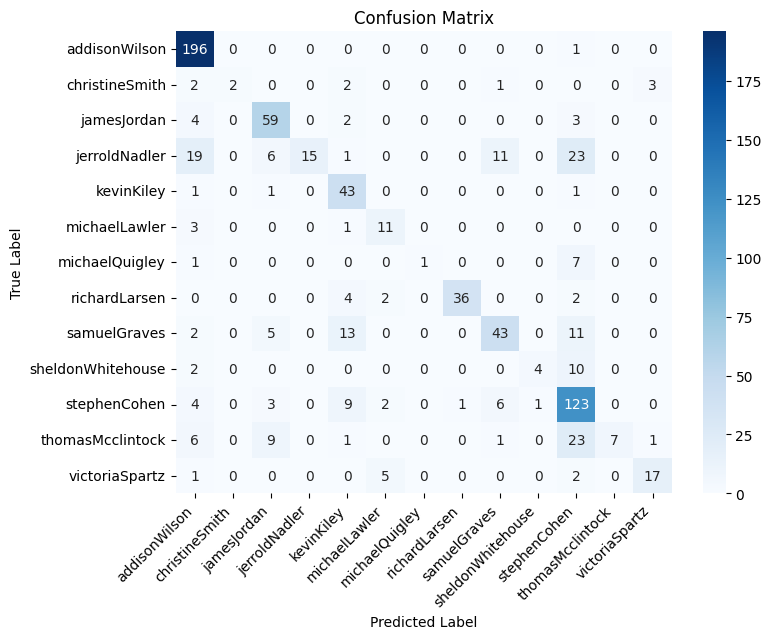

In [ ]:
y_pred_probabilities = gru.predict(X_test_rnn)
print("Prediction time:", time.time() - start_time)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print(len(y_pred_decoded))
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()